# SeisDownload Tutorial
#### June 6 2019

## Installation
1. IJulia to run Julia with Jupyter notebook

If you get warning when opening this notebook, you may miss "IJulia". Please open your terminal and open julia shell, then type as following:

**`Pkg.add` command will fail from this notebook. Please use Julia REPL.**

In [14]:
using Pkg; Pkg.add("IJulia");

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


2. Dependent packages

In [2]:
using Pkg; Pkg.pkg"add https://github.com/jpjones76/SeisIO.jl;";
Pkg.add(["Dates", "Distributed", "Printf", "JLD2", "FileIO", "ProgressMeter", "Suppressor"]);

  Updating git-repo `https://github.com/jpjones76/SeisIO.jl`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


3. Obspy

Follow the official instruction [Link](https://github.com/obspy/obspy/wiki/Installation-via-Anaconda).
After installing anaconda with brew or other package manager (e.g. pyenv), type on terminal:
> conda config --add channels conda-forge <br>
conda create -n obspy python=3.7   # or e.g. python=2.7 <br>
conda activate obspy  # this command used to be 'source activate obspy' on older conda versions < 4.4 <br>
(obspy) conda install obspy

**Use SeisDownload with activating obspy enviroment due to the dependency of resp removal for $\beta$ version**  

4. Pycall with obspy enviroment

Firstly, type `which python` with obspy enviroment and copy the link to the python. 

(usually in $path-to-anaconda-package/anaconda3-5.x.x/envs/obspy/bin/python)

Then,

In [3]:
type "]",then add Pycall
ENV["PYTHON"] = "$path-to-anaconda-package/anaconda3-5.x.x/envs/obspy/bin/python" # python 2.x may cause a problem; try python 3.x
Pkg.build("PyCall")

LoadError: syntax: extra token """ after end of expression

You are now all set!

## Example to donwload data

In [4]:
# with β version, please import SeisDownload.jl from the src directory as follows
include("./src/SeisDownload.jl")
using .SeisDownload

┌ Info: Recompiling stale cache file /Users/kurama/.julia/compiled/v1.1/SeisIO/P86QT.ji for SeisIO [b372bb87-02dd-52bb-bcf6-c30dd83fd342]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/kurama/.julia/compiled/v1.1/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1184


In [5]:
using SeisIO, Dates, Distributed

#==================================================#
# Input Parameters
NP = 3 # number of processor
DownloadType = "Noise" # Choise of "Noise" or "Earthquake"

network     = ["BP"]
station     = ["LCCB", "MMNB"]
location    = [""]
channel     = ["BP1", "BP2"]
datacenter  = "FDSN" #Data center
src         = "NCEDC"

# Time info for Noise case
starttime   = DateTime(2004,9,28,16,0,0)
endtime     = DateTime(2004,9,28,19,0,0)
DL_time_unit = 3600 #3600 * 24 # Download tiem unit [s] more than one day is better to avoid artifacts of response removal

pre_filt    = (0.001, 0.002, 10.0, 20.0) #prefilter tuple used obspy remove_response: taper between f1 and f2, f3 and f4 with obspy

foname      = "BPnetwork"; # data is saved at ./dataset/$foname.jld2
#==================================================#

In [6]:
# allocate cpus
addprocs(NP-1)

@everywhere include("./src/SeisDownload.jl")
@everywhere include("./src/utils.jl")
#using SeisIO, Dates, SeisDownload
@everywhere using .SeisDownload, .Utils

In [7]:
# store metadata in Dictionary
# This can be customized by users

stationlist       = String[]
stationdatacenter = String[]
stationsrc        = String[]
for i=1:length(network)
    for j=1:length(station)
        for k=1:length(location)
            for l=1:length(channel)
                stationname = join([network[i], station[j], location[k], channel[l]], ".")
                push!(stationlist, stationname)

                #Here should be improved for multiple seismic network; we have to make
                #proper conbination of request station and data server.
                push!(stationdatacenter, datacenter)
                push!(stationsrc, src)
            end
        end
    end
end

stationinfo = Dict(["stationlist" => stationlist, "stationdatacenter" => stationdatacenter, "stationsrc" => stationsrc])

mkpath("./dataset")
fopath=("./dataset/"*foname*".jld2")

InputDictionary = Dict([
      "DownloadType"=> DownloadType,
      "stationinfo" => stationinfo,
      "starttime"   => starttime,
      "endtime"     => endtime,
      "DL_time_unit"=> DL_time_unit,
      "pre_filt"    => pre_filt,
      "fopath"      => fopath
    ])

Dict{String,Any} with 7 entries:
  "pre_filt"     => (0.001, 0.002, 10.0, 20.0)
  "stationinfo"  => Dict("stationdatacenter"=>["FDSN", "FDSN", "FDSN", "FDSN"],…
  "DownloadType" => "Noise"
  "starttime"    => 2004-09-28T16:00:00
  "endtime"      => 2004-09-28T19:00:00
  "fopath"       => "./dataset/BPnetwork.jld2"
  "DL_time_unit" => 3600

In [17]:
InputDictionary
InputDictionary["stationinfo"]

Dict{String,Array{String,1}} with 3 entries:
  "stationdatacenter" => ["FDSN", "FDSN", "FDSN", "FDSN"]
  "stationlist"       => ["BP.LCCB..BP1", "BP.LCCB..BP2", "BP.MMNB..BP1", "BP.M…
  "stationsrc"        => ["NCEDC", "NCEDC", "NCEDC", "NCEDC"]

In [8]:
# mass request with input Dictionary
SeisDownload.ParallelSeisrequest(NP, InputDictionary)



      _____        _       _____                          _                    _
     / ____|      (_)     |  __ \                        | |                  | |
    | (___    ___  _  ___ | |  | |  ___ __      __ _ __  | |  ___    __ _   __| |
     \___ \  / _ \| |/ __|| |  | | / _ \\ \ /\ / /| '_ \ | | / _ \  / _` | / _` |
     ____) ||  __/| |\__ \| |__| || (_) |\ V  V / | | | || || (_) || (_| || (_| |
    |_____/  \___||_||___/|_____/  \___/  \_/\_/  |_| |_||_| \___/  \__,_| \__,_|
                      _         _  _
                     | |       | |(_)           |
    __      __       | | _   _ | | _   __ _     | v1.0 (Last update 06/06/2019)
    \ \ /\ / /   _   | || | | || || | / _` |    | © Kurama Okubo
     \ V  V /_  | |__| || |_| || || || (_| |    |
      \_/\_/(_)  \____/  \__,_||_||_| \__,_|    |

Job start running at 2019-06-07T12:08:38.404

job ended at 2019-06-07T12:09:52.262


Now downloaded dataset is in `./dataset`. The dataset is in SeisData format. Only instrumental response removal is applied on the data.

### Plot results 

In [9]:
using JLD2, FileIO
t = jldopen("./dataset/BPnetwork.jld2")

JLDFile /Users/kurama/Documents/kurama/research/SeisDownload_tutorial/dataset/BPnetwork.jld2 (read-only)
 ├─📂 info
 │  ├─🔢 DLtimestamplist
 │  ├─🔢 stationlist
 │  ├─🔢 starttime
 │  ├─🔢 endtime
 │  └─🔢 DL_time_unit
 ├─📂 2004.272.T16:00:00
 │  ├─🔢 BP.LCCB..BP1
 │  ├─🔢 BP.LCCB..BP2
 │  ├─🔢 BP.MMNB..BP1
 │  └─🔢 BP.MMNB..BP2
 ├─📂 2004.272.T17:00:00
 │  ├─🔢 BP.LCCB..BP1
 │  ├─🔢 BP.LCCB..BP2
 │  ├─🔢 BP.MMNB..BP1
 │  └─🔢 BP.MMNB..BP2
 ├─📂 2004.272.T18:00:00
 │  ├─🔢 BP.LCCB..BP1
 │  ├─🔢 BP.LCCB..BP2
 │  ├─🔢 BP.MMNB..BP1
 │  └─🔢 BP.MMNB..BP2
 └─📂 2004.272.T19:00:00
    ├─🔢 BP.LCCB..BP1
    ├─🔢 BP.LCCB..BP2
    ├─🔢 BP.MMNB..BP1
    └─🔢 BP.MMNB..BP2

In [19]:
t["info/DLtimestamplist"]
S = t["2004.272.T19:00:00/BP.LCCB..BP1"]

SeisChannel with 72000 samples
    ID: BP.LCCB..BP1
  NAME: Little Cholame Creek, Parkfield, CA, USA
   LOC: 35.9801 N, -120.514 E, 637.0 m
    FS: 20.0
  GAIN: 7.18559e10
  RESP: c = 1.0, 2 zeros, 2 poles
 UNITS: M/S
   SRC: http://service.ncedc.org/fdsnws/dataselect/1/query
  MISC: 2 entries
 NOTES: 1 entries
     T: 2004-09-28T19:00:00.020 (0 gaps)    
     X: +4.492e-07                          
        +4.481e-07                          
            ...                             
        -6.019e-07                          
        (nx = 72000)                        

In [28]:
plotstationid = t["info/stationlist"][1];
plottimestamp = t["info/DLtimestamplist"][2];

In [29]:
S = t[joinpath(plottimestamp, plotstationid)]

SeisChannel with 72000 samples
    ID: BP.LCCB..BP1
  NAME: Little Cholame Creek, Parkfield, CA, USA
   LOC: 35.9801 N, -120.514 E, 637.0 m
    FS: 20.0
  GAIN: 7.18559e10
  RESP: c = 1.0, 2 zeros, 2 poles
 UNITS: M/S
   SRC: http://service.ncedc.org/fdsnws/dataselect/1/query
  MISC: 2 entries
 NOTES: 1 entries
     T: 2004-09-28T17:00:00.020 (0 gaps)    
     X: +1.126e-05                          
        +1.122e-05                          
            ...                             
        +3.005e-05                          
        (nx = 72000)                        

In [30]:
using Plots; gr()
tvec = collect(0:S.t[2,1]-1) / S.fs;

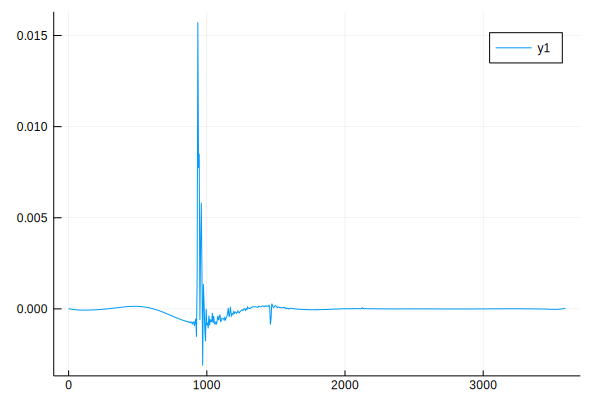

In [31]:
plotspan = 100;
plot(tvec[1:plotspan:end], S.x[1:plotspan:end])